# Online Recovery of Temporally Correlated Sparse Signals Using Multiple Measurement Vectors

In [207]:
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
sns.set_style("darkgrid")

## Numerical Setup

In [32]:
N=50
M = 20 # Number of measurements 
S = 5 # Number of non-zero coefficents 
K = 40
sparse_support= sp.random.choice(N, S, replace=False) # s locations chosen uniformly at random
Delta=10 # Time lag allowed in estimation 
Phi = sp.random.normal(0, 1, (K, M, N)) # K measurement matrices

In [33]:
def get_x_k(k, D_coeffs, z_coeffs, x_0_coeffs):
    if k == 0:
        return x_0_coeffs
    else: 
        return  D_coeffs*get_x_k(k-1, D_coeffs, z_coeffs, x_0_coeffs) + z_coeffs[k]

# Generated via the AR process
def get_x(K, sparse_support):
    S=len(sparse_support)
    x_0_coeffs = sp.random.normal(0, 1, S) 
    D_coeffs = sp.random.uniform(0.8, 1.0, S) # Correlation matrix with diagnonal entries chosen uniformly from [0.8, 1]
    z_coeffs = sp.random.normal(0, (1-D_coeffs**2)[1], (K, S))
    x=[sp.sparse.csr_matrix((get_x_k(k, D_coeffs, z_coeffs, x_0_coeffs), (
        sparse_support, sp.zeros(S))), shape=(N,1)) for k in range(K)]
    return sp.sparse.hstack(x), D_coeffs, z_coeffs

In [74]:
x, D_coeffs, z_coeffs = get_x(40, sparse_support)

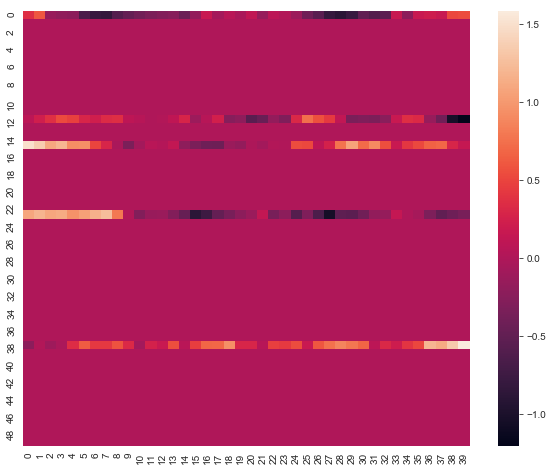

In [75]:
sns.heatmap(x.todense())

In [31]:
def get_y_k(k, x, Phi, noise=0):
    return Phi[k]*x.todense()[:,k] + noise

In [443]:
get_y_k(0, x, Phi)

matrix([[ 0.16122536],
        [ 2.12959573],
        [-2.12617323],
        [ 4.52410332],
        [-0.92371779],
        [-3.16099036],
        [-1.17462538],
        [ 1.15076723],
        [-1.15305712],
        [-1.95627503],
        [-0.15277197],
        [-0.84551283],
        [ 1.80881252],
        [ 1.09408158],
        [-1.3108321 ],
        [-2.95810325],
        [ 3.0910704 ],
        [ 1.75078184],
        [ 2.11092756],
        [-1.95304578]])

## Performance Metrics

### Mean Squared Error (MSE)

In [161]:
# Inputs are NxK matrices 
# For array inputs need **2, for sparse matrices can do .power
# Text for correct axis: 
# testx = sp.sparse.csr_matrix([[0, 0],[0, 0]])
# testxh = sp.sparse.csr_matrix([[1,0],[1, 0]])
# Answer should be [1., 0.], before summing
def get_mse(x_hat, x):
    return ((x_hat - x).power(2)).mean(axis=0).sum()

### Support Recovery Rate (SRR)

In [223]:
# x_hat is a scipy sparse NxK matrix 
# for each k, computes the number of support indices the estimate missed, 
# divided by the cardinaity of the sparse support, then averages over k
# 1-miss rate ===> success rate
def get_ssr(x_hat, sparse_support):
    x_sup = set(sparse_support)
    # make support dictionary from the nonzero elements of x_hat
    x_hat_sup = defaultdict(list)
    for i, k in zip(*x_hat.nonzero()):
        x_hat_sup[k].append(i)
    return 1-sp.mean([len(x_sup.difference(set(x_hat_sup[k])))/float(len(x_sup)) 
                      for k in range(x_hat.shape[1])])

### Run Time

In [206]:
%%timeit -n1
1+1

1 loop, best of 3: 0 ns per loop


## Fixed Lag KSBL